In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
db = 'chinook.db'

Setting up helper functions allows commands to be run more easily

In [2]:
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q,conn)

In [3]:
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    q = """SELECT
    name,
    type
    FROM sqlite_master
    WHERE type IN ("table","view");"""
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [5]:
run_query("SELECT * FROM Genre LIMIT 10")

,genre_id,name
0,1,Rock
1,2,Jazz
2,3,Metal
3,4,Alternative & Punk
4,5,Rock And Roll
5,6,Blues
6,7,Latin
7,8,Reggae
8,9,Pop
9,10,Soundtrack


When deciding on a factor such as which new albums to purchase and sell, we can run a query which selects and displays the top selling genres. If given a list of available albums and their genres, a decision could be made about which albums to purchase. 

LIST OF AVAILABLE ALBUMS:

- Punk
- Blues
- Hip Hop
- Jazz
- Pop


In [6]:
albums_for_purchasing = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

data = run_query(albums_for_purchasing)

In [7]:
data.head(10)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Since the results are ordered it is clear what sells best, however a figure is always best for displaying results such as these

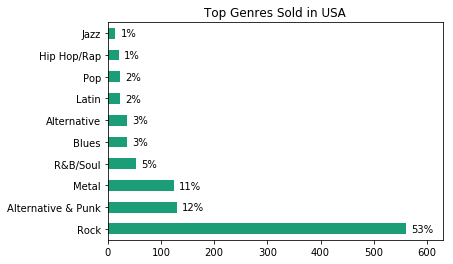

In [8]:
data.set_index("genre",drop=True,inplace=True)

data["tracks_sold"].plot.barh(
    title = "Top Genres Sold in USA", colormap="Dark2",
    xlim=(0, 630))

plt.ylabel('')

for i, label in enumerate(list(data.index)):
    score = data.loc[label, "tracks_sold"]
    label = (data.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the sales of albums in different genres, we should purchase albums with the following genres:

- Punk
- Blues
- Pop

Note that rock is by far the top selling genre, but not in the list of potential albums to sell. Note that the decision will often involve more nuance than selecting the top sellers, particularly when values are similar. We can also use a similar process to find the top-performing salesperson.

In [9]:
employee_sales = '''SELECT
    e.first_name || " " || e.last_name employee_name,
    e.hire_date,
    SUM(i.total) total_sales_$
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id

GROUP BY 1
ORDER BY 3 DESC
;
'''
data1 = run_query(employee_sales)

In [10]:
data1.head(10)

,employee_name,hire_date,total_sales_$
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


In [11]:
data1.set_index("employee_name",drop=True,inplace=True)

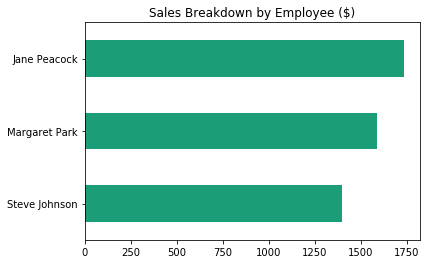

In [13]:
data1.sort_values("total_sales_$", inplace=True)
data1.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee ($)',
    colormap=plt.cm.Dark2
)
plt.ylabel('')
plt.show()

While JP has sold the highest value, MP is similar and SJ's performance would be best if date were taken into account ($139 versus $87 per month).

We can use a similar process to produce a breakdown of sales and number of customers per country:

In [14]:
sales_by_country_query = '''
WITH country_or_other AS
    (
     SELECT
        CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

sales_by_country = run_query(sales_by_country_query)

In [20]:
sales_by_country

,customers,total_sales,average_order,customer_lifetime_value
country,,,,
USA,13,1040.49,7.942672,80.037692
Canada,8,535.59,7.047237,66.948750
Brazil,5,427.68,7.011148,85.536000
France,5,389.07,7.781400,77.814000
Germany,4,334.62,8.161463,83.655000
Czech Republic,2,273.24,9.108000,136.620000
United Kingdom,3,245.52,8.768571,81.840000
Portugal,2,185.13,6.383793,92.565000
India,2,183.15,8.721429,91.575000


While 'Other' represents a significant portion of sales, we will exclude for the purposes of looking at performance of individual countries

In [21]:
sales_by_country_no_other = sales_by_country[0:9]

In [23]:
sales_by_country_no_other

,customers,total_sales,average_order,customer_lifetime_value
country,,,,
USA,13,1040.49,7.942672,80.037692
Canada,8,535.59,7.047237,66.948750
Brazil,5,427.68,7.011148,85.536000
France,5,389.07,7.781400,77.814000
Germany,4,334.62,8.161463,83.655000
Czech Republic,2,273.24,9.108000,136.620000
United Kingdom,3,245.52,8.768571,81.840000
Portugal,2,185.13,6.383793,92.565000
India,2,183.15,8.721429,91.575000


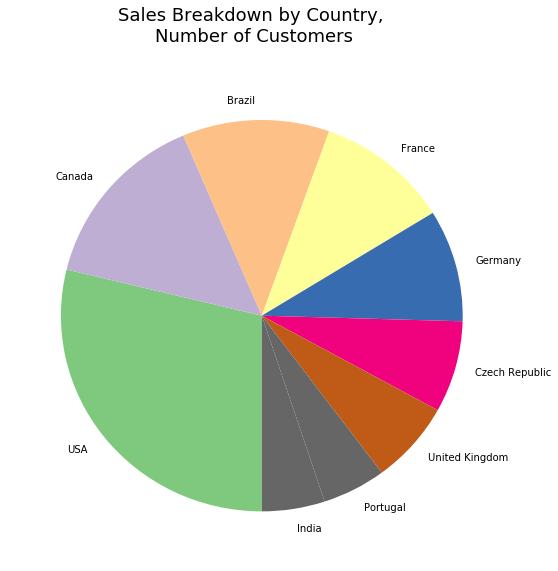

In [24]:
sales_breakdown = sales_by_country_no_other["total_sales"].copy().rename('')
plt.suptitle('Sales Breakdown by Country, \nNumber of Customers', fontsize=18)
sales_breakdown.plot.pie(
    figsize = (9,9),
    startangle=-90,
    counterclock=False,
    colormap=plt.cm.Accent,
    fontsize=10,
    wedgeprops={'linewidth':0}
    
)

While this graph can help to prioritize individual countries, it should be noted that it does not represent all countries, only those above a certain threshold.

Another metric we can look at is the ratio of customers to sales in each individual country:

/Users/peter/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


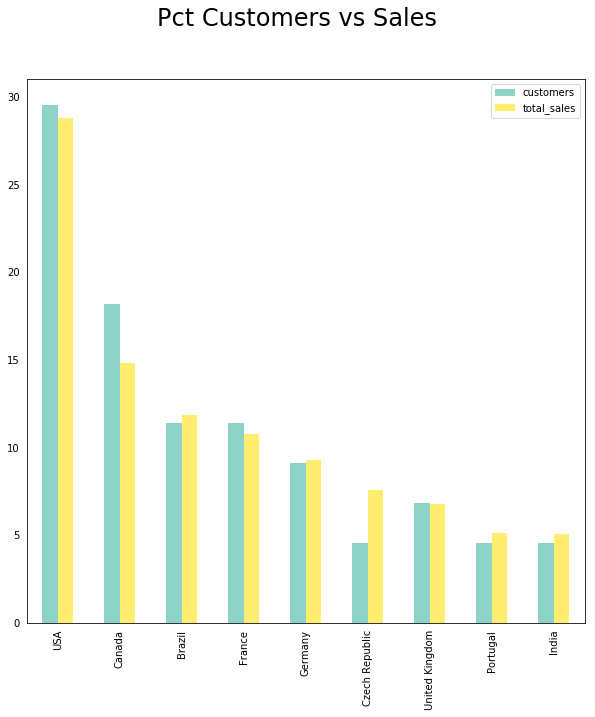

In [31]:
cols = ["customers","total_sales"]
customer_v_dollars = sales_by_country_no_other[cols]
customer_v_dollars.index.name = ''

for c in cols:
    customer_v_dollars[c] /= customer_v_dollars[c].sum() / 100
customer_v_dollars.plot.bar(
    figsize = (10,10),
    colormap=plt.cm.Set3)

plt.tick_params(top="off", right="off", left="off", bottom="off")
plt.suptitle("Pct Customers vs Sales", fontsize=24)


The proportion of sales to customers in each country is similar. Czech Republic a good ratio of sales to customers, Canada is the worst.

The average value of orders can also be investigated by producing a plot with each country's percent difference from the mean.

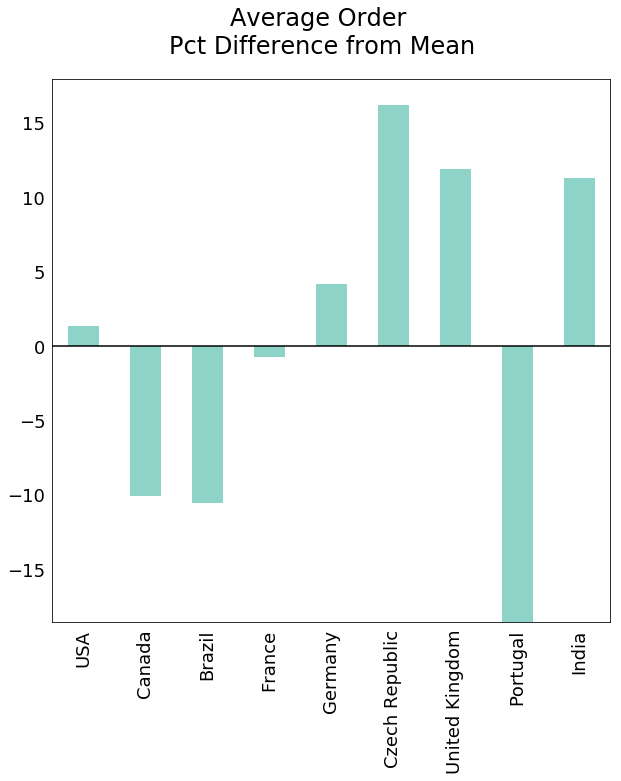

In [32]:
average_value = sales_by_country["average_order"].copy()
average_value.index.name = ''
diff_from_average = average_value * 100 / average_value.mean() - 100
diff_from_average.drop("Other", inplace = True)
plt.suptitle('Average Order \nPct Difference from Mean', fontsize=24)

diff_from_average.plot.bar(
    figsize = (10,10),
    colormap=plt.cm.Set3,
    fontsize=18
)
plt.tick_params(top="off", right="off", left="off", bottom="off")
plt.axhline(0, color='k')

This graph can be used to identify underperforming and well-performing countries. Portugal brings by far the least value per sale.

A bar graph can also be used to identify countries with the highest customer lifetime values:

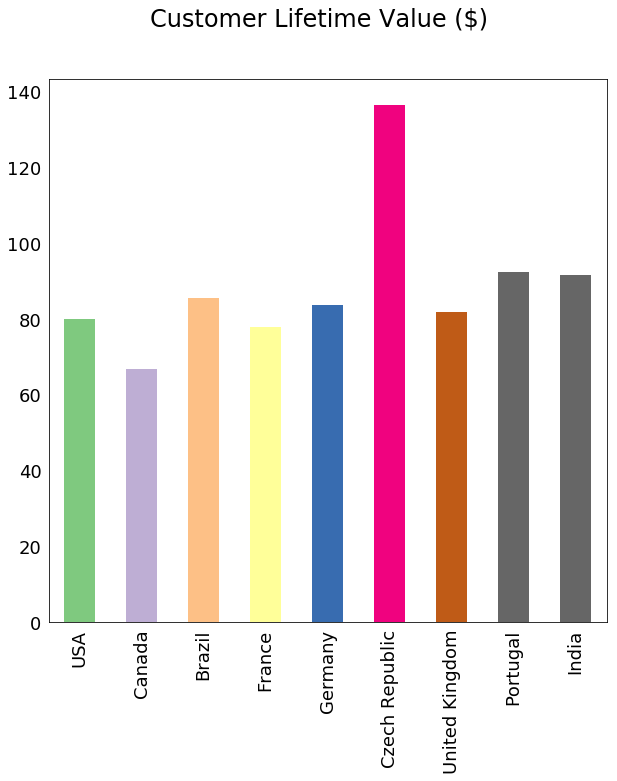

In [33]:
import numpy as np
life_value = sales_by_country["customer_lifetime_value"].copy()
life_value.index.name = ''
life_value.drop("Other", inplace = True)
plt.suptitle('Customer Lifetime Value ($)', fontsize=24)

life_value.plot.bar(
    figsize = (10,10),
    color = [plt.cm.Accent(i) for i in np.linspace(0, 1, life_value.shape[0])],
    fontsize=18
)
plt.tick_params(top="off", right="off", left="off", bottom="off")

Czech Republic is the highest earner. This graph makes an interesting contrast compared to the previous one, with Portuguese customers having a relatively high lifetime value even if their average orders are low.

We can also find out what percentage of purchases are albums vs tracks:

In [34]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, it could be recommended that purchasing only select tracks from albums from record companies is a bad idea, since there is potential to lose one fifth of revenue.